# Structured and time series data

In [4]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [5]:
import torch

In [6]:
from fastai.structured import *
from fastai.column_data import *
from datetime import *
from math import *
np.set_printoptions(threshold=50, edgeitems=20)

PATH='data/taxiprice/'

## Create datasets

In [6]:
table_names = ['train', 'test']

In [7]:
tables = [pd.read_csv(f'{PATH}{fname}.csv', low_memory=False) for fname in table_names]

In [8]:
from IPython.display import HTML

In [9]:
for t in tables: display(t.head())

,ID,TAXI_ID,TIMESTAMP,DURATION,X_START,Y_START,X_END,Y_END,X_TRAJECTORY,Y_TRAJECTORY,TRAJ_LENGTH
0,1,127,2009-03-07 07:48:56,223,-223,-350,-124,-39,"-223, -225, -225, -221, -217, -209, -212, -204...","-350, -347, -342, -336, -329, -321, -324, -324...",439
1,2,420,2008-07-18 09:24:20,359,-257,-73,-326,-292,"-257, -257, -260, -262, -263, -263, -262, -262...","-73, -75, -86, -100, -111, -121, -133, -138, -...",260
2,3,56,2009-03-10 10:29:21,162,-320,-300,-332,-254,"-320, -324, -329, -334, -340, -340, -340, -340...","-300, -301, -301, -297, -298, -295, -295, -294...",135
3,4,133,2008-09-03 15:27:24,124,-352,-233,-380,-189,"-352, -354, -356, -356, -356, -356, -356, -356...","-233, -233, -234, -234, -234, -233, -234, -230...",70
4,5,545,2008-09-22 13:15:52,219,-350,-232,-301,-300,"-350, -350, -350, -350, -350, -352, -355, -354...","-232, -232, -232, -232, -232, -232, -233, -236...",117


,ID,TAXI_ID,TIMESTAMP,X_START,Y_START,X_END,Y_END
0,465173,251,2008-08-23 18:47:30,-331,-102,-396,-95
1,465174,560,2008-08-22 14:44:52,-293,-129,-275,-190
2,465175,212,2008-07-25 19:12:20,-381,-190,-285,-266
3,465176,279,2009-04-20 11:51:23,-150,-25,-153,-382
4,465177,84,2008-06-13 08:10:20,-326,-302,-350,-198


In [11]:
for t in tables: display(DataFrameSummary(t).summary())

,ID,TAXI_ID,TIMESTAMP,DURATION,X_START,Y_START,X_END,Y_END,X_TRAJECTORY,Y_TRAJECTORY,TRAJ_LENGTH
count,465172,465172,NaN,465172,465172,465172,465172,465172,NaN,NaN,465172
mean,232586,324.12,NaN,253.242,-274.488,-248.023,-243.426,-238.723,NaN,NaN,242.228
std,134284,213.339,NaN,108.412,79.727,76.579,117.362,95.0577,NaN,NaN,149.919
min,1,1,NaN,120,-381,-415,-431,-419,NaN,NaN,21
25%,116294,148,NaN,174,-340,-296,-330,-300,NaN,NaN,137
50%,232586,298,NaN,226,-296,-272,-267,-263,NaN,NaN,200
75%,348879,454,NaN,301,-223,-202,-190,-191,NaN,NaN,303
max,465172,800,NaN,883,-42,-12,426,68,NaN,NaN,999
counts,465172,465172,465172,465172,465172,465172,465172,465172,465172,465172,465172
uniques,465172,800,461201,752,340,404,849,488,465172,465172,979


,ID,TAXI_ID,TIMESTAMP,X_START,Y_START,X_END,Y_END
count,465172,465172,NaN,465172,465172,465172,465172
mean,697758,324.228,NaN,-274.316,-248.352,-243.017,-238.544
std,134284,213.566,NaN,79.921,76.231,117.589,95.2304
min,465173,1,NaN,-381,-415,-431,-419
25%,581466,148,NaN,-340,-296,-330,-300
50%,697758,297,NaN,-296,-272,-266,-263
75%,814051,455,NaN,-223,-203,-190,-191
max,930344,800,NaN,-42,-12,426,68
counts,465172,465172,465172,465172,465172,465172,465172
uniques,465172,800,461336,340,404,853,488


## Data Cleaning / Feature Engineering

In [12]:
train, test = tables

In [13]:
len(train),len(test)

(465172, 465172)

In [14]:
train['Price'] = train['DURATION'] + train['TRAJ_LENGTH']

In [15]:
#train['TIMESTAMP'] = pd.to_datetime(train['TIMESTAMP'])
#test['TIMESTAMP'] = pd.to_datetime(test['TIMESTAMP'])

In [16]:
import re

def add_datetimepart(df, fldname, drop=True):
    fld = df[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ('Year', 'Month', 'Week', 'Day', 'Dayofweek',
            'Is_month_end', 'Is_month_start', 'Is_year_end', 'Is_year_start',
            'Hour', 'Minute',):
        df[targ_pre+n] = getattr(fld.dt,n.lower())
    df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [17]:
add_datetimepart(train, "TIMESTAMP", drop=False)
add_datetimepart(test, "TIMESTAMP", drop=False)

In [18]:
train['Holiday'] = train['TIMESTAMPDayofweek'] >= 5
test['Holiday'] = test['TIMESTAMPDayofweek'] >= 5

In [19]:
train.columns

Index(['ID', 'TAXI_ID', 'TIMESTAMP', 'DURATION', 'X_START', 'Y_START', 'X_END',
       'Y_END', 'X_TRAJECTORY', 'Y_TRAJECTORY', 'TRAJ_LENGTH', 'Price',
       'TIMESTAMPYear', 'TIMESTAMPMonth', 'TIMESTAMPWeek', 'TIMESTAMPDay',
       'TIMESTAMPDayofweek', 'TIMESTAMPIs_month_end',
       'TIMESTAMPIs_month_start', 'TIMESTAMPIs_year_end',
       'TIMESTAMPIs_year_start', 'TIMESTAMPHour', 'TIMESTAMPMinute',
       'TIMESTAMPElapsed', 'Holiday'],
      dtype='object')

In [20]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [21]:
def dummy_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

In [22]:
def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [23]:
train['distance_haversine'] = haversine_array(
        train['X_START'].values, train['Y_START'].values,
        train['X_END'].values, train['Y_END'].values)
test['distance_haversine'] = haversine_array(
        test['X_START'].values, test['Y_START'].values,
        test['X_END'].values, test['Y_END'].values)

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


In [24]:
train['distance_dummy'] = dummy_distance(
        train['X_START'].values, train['Y_START'].values,
        train['X_END'].values, train['Y_END'].values)
test['distance_dummy'] = dummy_distance(
        test['X_START'].values, test['Y_START'].values,
        test['X_END'].values, test['Y_END'].values)

In [25]:
train['center_latitude'] = (train['X_START'].values + train['X_END'].values) / 2
test['center_latitude'] = (test['X_START'].values + test['X_END'].values) / 2

In [26]:
train['center_longitude'] = (train['Y_START'].values + train['Y_END'].values) / 2
test['center_longitude'] = (test['Y_START'].values + test['Y_END'].values) / 2

In [27]:
train['direction'] = bearing_array(
        train['X_START'].values, train['Y_START'].values,
        train['X_END'].values, train['Y_END'].values)
test['direction'] = bearing_array(
        test['X_START'].values, test['Y_START'].values,
        test['X_END'].values, test['Y_END'].values)

In [28]:
train['direction_ns'] = (train.X_START > train.X_END) * 1 + 1
indices = train[(train.X_START == train.X_END) & (train.X_START != 0)].index
train.loc[indices, 'direction_ns'] = 0
test['direction_ns'] = (test.X_START > test.X_END) * 1 + 1
indices = test[(test.X_START == test.X_END) & (test.X_START != 0)].index
test.loc[indices, 'direction_ns'] = 0

In [29]:
train['direction_ew'] = (train.Y_START > train.Y_END) * 1 + 1
indices = train[(train.Y_START == train.Y_END) & (train.Y_START != 0)].index
train.loc[indices, 'direction_ew'] = 0
test['direction_ew'] = (test.Y_START > test.Y_END) * 1 + 1
indices = test[(test.Y_START == test.Y_END) & (test.Y_START != 0)].index
test.loc[indices, 'direction_ew'] = 0

In [30]:
from sklearn.decomposition import PCA

In [31]:
full = pd.concat([train, test]).reset_index(drop=True)
coords = np.vstack((full[['X_START', 'Y_START']], full[['X_END', 'Y_END']]))

In [32]:
pca = PCA().fit(coords)

In [33]:
train['pickup_pca0'] = pca.transform(train[['X_START', 'Y_START']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['X_START', 'Y_START']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['X_END', 'Y_END']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['X_END', 'Y_END']])[:, 1]
test['pickup_pca0'] = pca.transform(test[['X_START', 'Y_START']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['X_START', 'Y_START']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['X_END', 'Y_END']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['X_END', 'Y_END']])[:, 1]

In [34]:
train['pca_distance'] = np.abs(train['dropoff_pca1'] - train['pickup_pca1']) + \
                             np.abs(train['dropoff_pca0'] - train['pickup_pca0'])
test['pca_distance'] = np.abs(test['dropoff_pca1'] - test['pickup_pca1']) + \
                             np.abs(test['dropoff_pca0'] - test['pickup_pca0'])

In [35]:
train['DISTANCE'] = np.sqrt((train['X_END'] - train['X_START']) ** 2 + (train['Y_END'] - train['Y_START']) ** 2)
test['DISTANCE'] = np.sqrt((test['X_END'] - test['X_START']) ** 2 + (test['Y_END'] - test['Y_START']) ** 2)

In [38]:
train['LOG_DISTANCE'] = np.log1p(train['DISTANCE'])
test['LOG_DISTANCE'] = np.log1p(test['DISTANCE'])

In [39]:
#train['LOG_DISTANCE'].hist()

## Skip this MeanShift part

In [40]:
from sklearn.cluster import MeanShift

In [41]:
geo_parameters=['X_START','Y_START']
pts_start = np.array(train[geo_parameters])

In [42]:
bw = 0.001
ms = MeanShift(bandwidth=bw, bin_seeding=True, min_bin_freq=5)
ms.fit(pts_start)

MeanShift(bandwidth=0.001, bin_seeding=True, cluster_all=True, min_bin_freq=5,
     n_jobs=1, seeds=None)

In [43]:
train['geolocation1']=ms.labels_
test['geolocation1'] = ms.predict(np.array(test[geo_parameters]))

In [44]:
bw = 0.0005
ms = MeanShift(bandwidth=bw, bin_seeding=True, min_bin_freq=5)
ms.fit(pts_start)

KeyboardInterrupt: 

In [31]:
train['geolocation2']=ms.labels_
test['geolocation2'] = ms.predict(np.array(test[geo_parameters]))

In [45]:
geo_parameters=['X_END','Y_END']
pts_end = np.array(train[geo_parameters])

In [46]:
bw = 0.001
ms = MeanShift(bandwidth=bw, bin_seeding=True, min_bin_freq=5)
ms.fit(pts_end)

MeanShift(bandwidth=0.001, bin_seeding=True, cluster_all=True, min_bin_freq=5,
     n_jobs=1, seeds=None)

In [47]:
train['geolocation1_end']=ms.labels_
test['geolocation1_end'] = ms.predict(np.array(test[geo_parameters]))

In [39]:
bw = 0.0005
ms = MeanShift(bandwidth=bw, bin_seeding=True, min_bin_freq=5)
ms.fit(pts_end)

MeanShift(bandwidth=0.0005, bin_seeding=True, cluster_all=True,
     min_bin_freq=5, n_jobs=1, seeds=None)

In [48]:
train['geolocation2_end']=ms.labels_
test['geolocation2_end'] = ms.predict(np.array(test[geo_parameters]))

KeyboardInterrupt: 

In [62]:
#columns = ['X_START_AREA', 'Y_START_AREA', 'X_END_AREA', 'Y_END_AREA']

In [68]:
#for t in columns:
#    train[t] = train[t].astype(np.int64)
#    test[t] = test[t].astype(np.int64)

In [49]:
train.to_feather(f'{PATH}joined')
test.to_feather(f'{PATH}joined_test')

## Select features

In [51]:
missing = train.isnull().sum()
missing = missing[missing > 0]; missing.sum()

0

In [53]:
missing = test.isnull().sum()
missing = missing[missing > 0]; missing

distance_haversine    1
dtype: int64

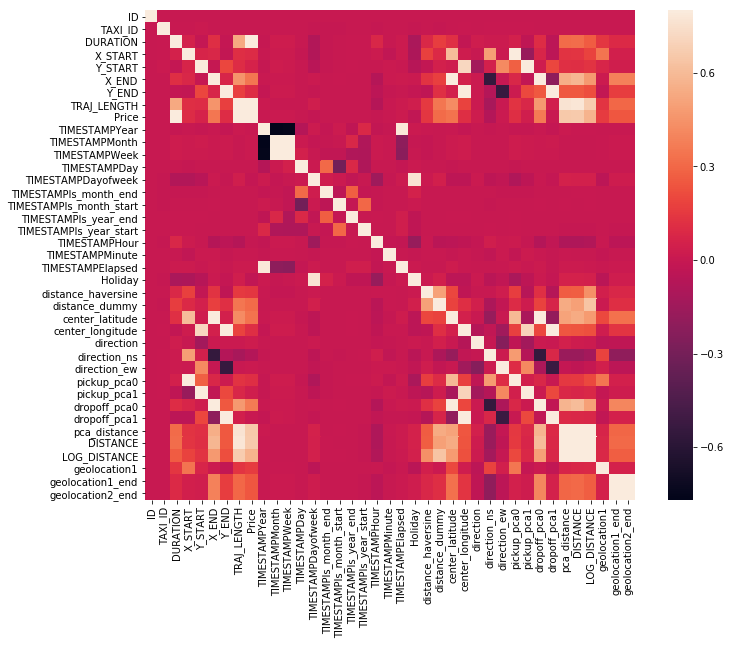

In [60]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

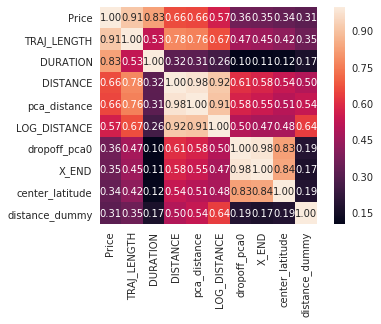

In [70]:
k = 10
cols = corrmat.nlargest(k, 'Price')['Price'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.00)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f',
                annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [77]:
corr_mat = train.corr(method='pearson')
corr_mat['Price'].sort_values(ascending=False)

Price                      1.000000
TRAJ_LENGTH                0.914306
DURATION                   0.828431
DISTANCE                   0.664438
pca_distance               0.655118
LOG_DISTANCE               0.567522
dropoff_pca0               0.360952
X_END                      0.352238
center_latitude            0.335323
distance_dummy             0.313267
geolocation2_end           0.243162
geolocation1_end           0.243162
geolocation1               0.158390
distance_haversine         0.141881
center_longitude           0.111916
pickup_pca0                0.110335
Y_END                      0.105873
X_START                    0.100598
Y_START                    0.063396
pickup_pca1                0.038897
direction                  0.023304
TIMESTAMPElapsed           0.021066
direction_ew               0.013955
TIMESTAMPMonth             0.013247
TIMESTAMPWeek              0.012866
dropoff_pca1               0.006028
TIMESTAMPMinute            0.005907
TIMESTAMPYear              0

## Create features

In [7]:
joined = pd.read_feather(f'{PATH}joined')
joined_test = pd.read_feather(f'{PATH}joined_test')

In [8]:
joined.head().T.head(40)

,0,1,2,3,4
ID,1,2,3,4,5
TAXI_ID,127,420,56,133,545
TIMESTAMP,2009-03-07 07:48:56,2008-07-18 09:24:20,2009-03-10 10:29:21,2008-09-03 15:27:24,2008-09-22 13:15:52
DURATION,223,359,162,124,219
X_START,-223,-257,-320,-352,-350
Y_START,-350,-73,-300,-233,-232
X_END,-124,-326,-332,-380,-301
Y_END,-39,-292,-254,-189,-300
X_TRAJECTORY,"-223, -225, -225, -221, -217, -209, -212, -204...","-257, -257, -260, -262, -263, -263, -262, -262...","-320, -324, -329, -334, -340, -340, -340, -340...","-352, -354, -356, -356, -356, -356, -356, -356...","-350, -350, -350, -350, -350, -352, -355, -354..."
Y_TRAJECTORY,"-350, -347, -342, -336, -329, -321, -324, -324...","-73, -75, -86, -100, -111, -121, -133, -138, -...","-300, -301, -301, -297, -298, -295, -295, -294...","-233, -233, -234, -234, -234, -233, -234, -230...","-232, -232, -232, -232, -232, -232, -233, -236..."


In [9]:
joined_test.head().T.head(40)

,0,1,2,3,4
ID,465173,465174,465175,465176,465177
TAXI_ID,251,560,212,279,84
TIMESTAMP,2008-08-23 18:47:30,2008-08-22 14:44:52,2008-07-25 19:12:20,2009-04-20 11:51:23,2008-06-13 08:10:20
X_START,-331,-293,-381,-150,-326
Y_START,-102,-129,-190,-25,-302
X_END,-396,-275,-285,-153,-350
Y_END,-95,-190,-266,-382,-198
TIMESTAMPYear,2008,2008,2008,2009,2008
TIMESTAMPMonth,8,8,7,4,6
TIMESTAMPWeek,34,34,30,17,24


In [11]:
cat_vars = [
#'TAXI_ID',
#            'TIMESTAMPYear', 'TIMESTAMPMonth', 'TIMESTAMPDayofweek',  'TIMESTAMPDay',
            'TIMESTAMPWeek',
#            'TIMESTAMPHour', 'TIMESTAMPMinute', 
#            'TIMESTAMPIs_month_end',
#            'TIMESTAMPIs_month_start', 'TIMESTAMPIs_year_end', 'TIMESTAMPIs_year_start',
            'geolocation1', 'geolocation1_end' ,
#          'direction_ns', 'Holiday',
            'direction_ew']

contin_vars = ['X_START', 'Y_START', 'Y_END', 'DISTANCE',
#            'X_END', 'distance_haversine', 'distance_dummy',
              'center_latitude', 'center_longitude',
              'direction', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0',
#               'dropoff_pca1', 'pca_distance'
              ]

n = len(joined); n

465172

In [12]:
dep = 'Price'
joined = joined[cat_vars+contin_vars+[dep, 'TIMESTAMP']].copy()

In [13]:
joined_test[dep] = 0
joined_test = joined_test[cat_vars+contin_vars+[dep, 'TIMESTAMP', 'ID']].copy()

In [14]:
for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()

In [15]:
apply_cats(joined_test, joined)

In [16]:
for v in contin_vars:
    joined[v] = joined[v].astype('float32')
    joined_test[v] = joined_test[v].astype('float32')

In [17]:
joined.T.head()

,0,1,2,3,4,5,6,7,8,9,...,465162,465163,465164,465165,465166,465167,465168,465169,465170,465171
TIMESTAMPWeek,10,29,11,36,39,3,45,43,8,9,...,51,8,50,21,35,28,36,3,5,3
geolocation1,555,456,2434,3017,69,93,77,164,1822,186,...,3,6,7766,9206,982,6,2402,390,111,1898
geolocation1_end,3194,78,591,0,13037,8580,8752,259,6226,5034,...,117,9894,977,12157,4323,2574,10310,15520,1941,18681
direction_ew,1,2,1,1,2,2,1,1,2,1,...,1,1,2,2,2,1,2,1,2,2
X_START,-223,-257,-320,-352,-350,-319,-360,-284,-303,-329,...,-318,-332,-308,-280,-249,-332,-247,-149,-277,-151


In [18]:
joined_test.head()

,TIMESTAMPWeek,geolocation1,geolocation1_end,direction_ew,X_START,Y_START,Y_END,DISTANCE,center_latitude,center_longitude,direction,pickup_pca0,pickup_pca1,dropoff_pca0,Price,TIMESTAMP,ID
0,34,109,12606,1,-331.0,-102.0,-95.0,65.375839,-363.5,-98.5,173.771454,-38.753819,153.968262,-100.544655,0,2008-08-23 18:47:30,465173
1,34,27,4259,2,-293.0,-129.0,-190.0,63.600315,-284.0,-159.5,-12.274961,-7.750252,119.157639,-3.840330,0,2008-08-22 14:44:52,465174
2,30,0,2287,2,-381.0,-190.0,-266.0,122.441826,-333.0,-228.0,-15.201685,-107.158478,79.370659,-30.574781,0,2008-07-25 19:12:20,465175
3,17,277,16895,2,-150.0,-25.0,-382.0,357.012604,-151.5,-203.5,-137.964600,154.877777,188.563156,72.157333,0,2009-04-20 11:51:23,465176
4,24,755,12330,1,-326.0,-302.0,-198.0,106.733315,-338.0,-250.0,73.823647,-78.584152,-42.089245,-78.730949,0,2008-06-13 08:10:20,465177


In [20]:
samp_size = n
joined_samp = joined.set_index("TIMESTAMP")

In [21]:
joined_samp.head(5)

,TIMESTAMPWeek,geolocation1,geolocation1_end,direction_ew,X_START,Y_START,Y_END,DISTANCE,center_latitude,center_longitude,direction,pickup_pca0,pickup_pca1,dropoff_pca0,Price
TIMESTAMP,,,,,,,,,,,,,,,
2009-03-07 07:48:56,10,555,3194,1,-223.0,-350.0,-39.0,326.377075,-173.5,-194.5,26.230589,11.080979,-111.897301,177.090698,662
2008-07-18 09:24:20,29,456,78,2,-257.0,-73.0,-292.0,229.612717,-291.5,-182.5,46.105305,39.856003,165.694122,-76.348961,619
2009-03-10 10:29:21,11,2434,591,1,-320.0,-300.0,-254.0,47.539455,-326.0,-277.0,93.119591,-72.288918,-41.480961,-73.703430,297
2008-09-03 15:27:24,36,3017,0,1,-352.0,-233.0,-189.0,52.153618,-366.0,-211.0,123.543365,-88.503517,30.976521,-105.960258,194
2008-09-22 13:15:52,39,69,13037,2,-350.0,-232.0,-300.0,83.815269,-325.5,-266.0,-30.501596,-86.330597,31.504183,-53.769627,336


In [23]:
df, y, nas, mapper = proc_df(joined_samp, 'Price', do_scale=True)
yl = np.log(y)

In [24]:
joined_test = joined_test.set_index("TIMESTAMP")

In [25]:
df_test, _, nas = proc_df(joined_test, 'Price', do_scale=False, skip_flds = ['ID'],
                                na_dict=nas)

In [26]:
df_test.head()

,TIMESTAMPWeek,geolocation1,geolocation1_end,direction_ew,X_START,Y_START,Y_END,DISTANCE,center_latitude,center_longitude,direction,pickup_pca0,pickup_pca1,dropoff_pca0
TIMESTAMP,,,,,,,,,,,,,,
2008-08-23 18:47:30,34,110,12607,2,-331.0,-102.0,-95.0,65.375839,-363.5,-98.5,173.771454,-38.753819,153.968262,-100.544655
2008-08-22 14:44:52,34,28,4260,3,-293.0,-129.0,-190.0,63.600315,-284.0,-159.5,-12.274961,-7.750252,119.157639,-3.840330
2008-07-25 19:12:20,30,1,2288,3,-381.0,-190.0,-266.0,122.441826,-333.0,-228.0,-15.201685,-107.158478,79.370659,-30.574781
2009-04-20 11:51:23,17,278,16896,3,-150.0,-25.0,-382.0,357.012604,-151.5,-203.5,-137.964600,154.877777,188.563156,72.157333
2008-06-13 08:10:20,24,756,12331,2,-326.0,-302.0,-198.0,106.733315,-338.0,-250.0,73.823647,-78.584152,-42.089245,-78.730949


In [27]:
train_ratio = 0.75
# train_ratio = 0.9
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(df)))

In [98]:
#val_idx = np.flatnonzero(
#    (df.index<=datetime.datetime(2014,9,17)) & (df.index>=datetime.datetime(2014,8,1)))

In [99]:
#val_idx=[0]

## DL

In [28]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

In [29]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl.astype(np.float32), cat_flds=cat_vars, bs=128,
                                       test_df=df_test)

In [30]:
#md = ColumnarModelData.from_data_frame(PATH, train, test)

In [31]:
cat_sz = [(c, len(joined_samp[c].cat.categories)+1) for c in cat_vars]

In [32]:
cat_sz

[('TIMESTAMPWeek', 53),
 ('geolocation1', 12490),
 ('geolocation1_end', 20123),
 ('direction_ew', 4)]

In [33]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [34]:
emb_szs

[(53, 27), (12490, 50), (20123, 50), (4, 2)]

In [35]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [110]:
m.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 60%|██████    | 1639/2726 [00:10<00:06, 158.78it/s, loss=0.375] 

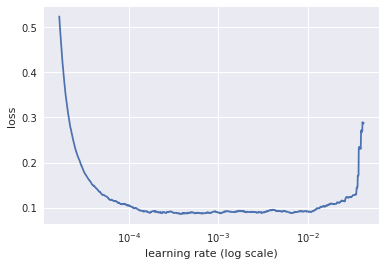

 60%|██████    | 1639/2726 [00:30<00:19, 54.58it/s, loss=0.375] 

In [111]:
m.sched.plot(100)

### Sample

In [56]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.1, 1, [1000,500], [0.05,0.1], y_range=y_range)
lr = 1e-4

In [57]:
m.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 83%|████████▎ | 2250/2726 [00:30<00:06, 74.92it/s, loss=0.585]  

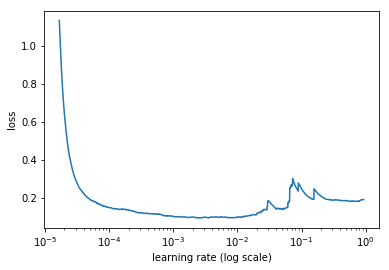

In [58]:
m.sched.plot(100)

In [59]:
lr = 1e-3

In [60]:
m.fit(lr, 3, metrics=[exp_rmspe])

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

 30%|██▉       | 817/2726 [00:06<00:14, 129.80it/s, loss=0.0839]

Exception in thread Thread-29:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   exp_rmspe                       
    0      0.072716   0.068238   0.230529  
    1      0.063412   0.068551   0.235731                        
    2      0.053654   0.069008   0.25182                         



[0.069008023, 0.25182020916245573]

In [53]:
m.fit(lr, 5, metrics=[exp_rmspe], cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   exp_rmspe                       
    0      0.043502   0.068941   0.257059  
    1      0.040897   0.070354   0.263824                        
    2      0.035753   0.071893   0.27097                         
    3      0.034574   0.073784   0.278938                        
 55%|█████▍    | 1498/2726 [00:10<00:08, 146.20it/s, loss=0.0299]

KeyboardInterrupt: 

In [ ]:
m.fit(lr, 2, metrics=[exp_rmspe], cycle_len=4)

In [ ]:
m.save('val0')

In [309]:
m.load('val0')

In [310]:
x,y=m.predict_with_targs()

In [311]:
exp_rmspe(x,y)

0.1310981522072182

In [313]:
pred_test=m.predict(is_test=True)

RuntimeError: running_mean should contain 17 elements not 15

In [116]:
pred_test = np.exp(pred_test)

In [117]:
joined_test['Price']= pred_test

In [118]:
csv_fn=f'{PATH}tmp/sub.csv'

In [119]:
joined_test[['ID','Price']].to_csv(csv_fn, index=False)

In [120]:
FileLink(csv_fn)

/home/paperspace/fastai/courses/dl1/data/taxiprice/tmp/sub.csv